## Setup

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Error importing in API mode: ImportError("dlopen(/Users/hgorledeenn/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <B96A8100-FA7A-3EFC-8726-931D26646DE6> /Users/hgorledeenn/.pyenv/versions/3.13.9/lib/python3.13/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [3]:
%%R 

library(tidycensus)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Step 1 \| Get a Census API key and replace it in the cell below

In [4]:
from dotenv import load_dotenv

# Load .env file
load_dotenv()

False

In [6]:
%%R 

# Set Census API key from environment variable
census_api_key(Sys.getenv("CENSUS_API_KEY"))

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Once you've found the variable or variables you want, you can plug them into this code under `variables`. 

In [7]:
%%R 

# the variable B01003_001 was selectd from the census table 
# for population, which we found in censusreporter here:
# https://censusreporter.org/tables/B01003/


# Here are the various geographies you can use with tidycensus
# https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus

# Get variable from ACS
nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",
                        total_units = "B25001_001",
                        med_inc="B19013_001"
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)

nyc_census_data


  |======================================================================| 100%
Simple feature collection with 6981 features and 5 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
First 10 features:
         GEOID                                       NAME    variable estimate
1  36081014700  Census Tract 147, Queens County, New York  population     2863
2  36081014700  Census Tract 147, Queens County, New York     med_inc    71815
3  36081014700  Census Tract 147, Queens County, New York total_units     1570
4  36047058400   Census Tract 584, Kings County, New York  population     3655
5  36047058400   Census Tract 584, Kings County, New York     med_inc    67315
6  36047058400   Census Tract 584, Kings County, New York total_units     1498
7  36061006900 Census Tract 69, New York County, New York  population     2450
8  36061006900 Census Tract 69, New York C

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'
In addition: Warning message:
• You have not set a Census API key. Users without a key are limited to 500
queries per day and may experience performance limitations.
ℹ For best results, get a Census API key at
http://api.census.gov/data/key_signup.html and then supply the key to the
`census_api_key()` function to use it throughout your tidycensus session.
This warning is displayed once per session. 


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [8]:
%%R 

nyc_census_data <- nyc_census_data |> 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  )# pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 8 fields (with 1 geometry empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 9
   GEOID    NAME                   geometry population_estimate med_inc_estimate
   <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608101… Cens… (((-73.9137 40.76548, -7…                2863            71815
 2 3604705… Cens… (((-73.96103 40.59616, -…                3655            67315
 3 3606100… Cens… (((-74.02064 40.73039, -…                2450           237500
 4 3604707… Cens… (((-73.93345 40.6257, -7…                2676           117857
 5 3604710… Cens… (((-73.90735 40.63083, -…                3004            76207
 6 3604705… Cens… (((-73.96279 40.72256, -…                1834           107410
 7 3600502… Cens… (((-73.92012 40.83759, -…                4030            37200
 8 3608104… Cens… (((-73

In [52]:
%%R

nyc_census_data <- nyc_census_data %>%
    filter(population_estimate>0)

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

In this example, we create a column called `borough` by extracting the borough from the `NAME` column.

_(hint, I used GitHub Copilot -- a tool similar to ChatGPT -- to do this...see my prompt in the comments)_

In [53]:
%%R 

# Extract borough name from NAME by splitting strings like "Census Tract 147, Queens County, New York" 
# on commas and extracting the second to last element

nyc_census_data <- nyc_census_data |> 
    mutate(
        borough = str_split(NAME, ",") |> map_chr(2) |> str_trim(),
        units_per_person = total_units_estimate / population_estimate
    ) 

nyc_census_data

Simple feature collection with 2239 features and 10 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25609 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,239 × 11
   GEOID    NAME                   geometry population_estimate med_inc_estimate
 * <chr>    <chr>        <MULTIPOLYGON [°]>               <dbl>            <dbl>
 1 3608101… Cens… (((-73.9137 40.76548, -7…                2863            71815
 2 3604705… Cens… (((-73.96103 40.59616, -…                3655            67315
 3 3606100… Cens… (((-74.02064 40.73039, -…                2450           237500
 4 3604707… Cens… (((-73.93345 40.6257, -7…                2676           117857
 5 3604710… Cens… (((-73.90735 40.63083, -…                3004            76207
 6 3604705… Cens… (((-73.96279 40.72256, -…                1834           107410
 7 3600502… Cens… (((-73.92012 40.83759, -…                4030            37200
 8 3608104… Cens… (((-73.78059 40.71343, -…   

### Step 5 | Example Plots

Let's practice with histograms

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.


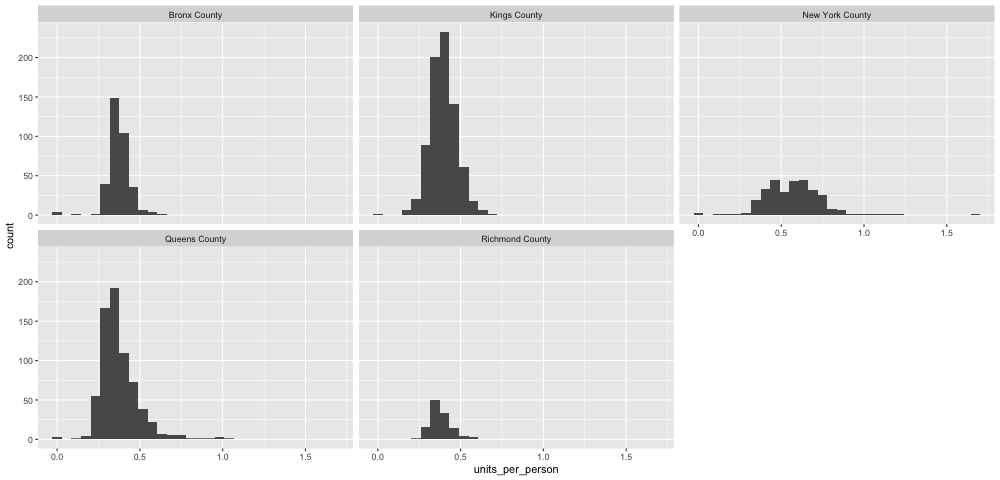

In [54]:
%%R -w 1000

ggplot(nyc_census_data) + 
    aes(x=units_per_person) +
    geom_histogram() + 
    facet_wrap(~borough) 

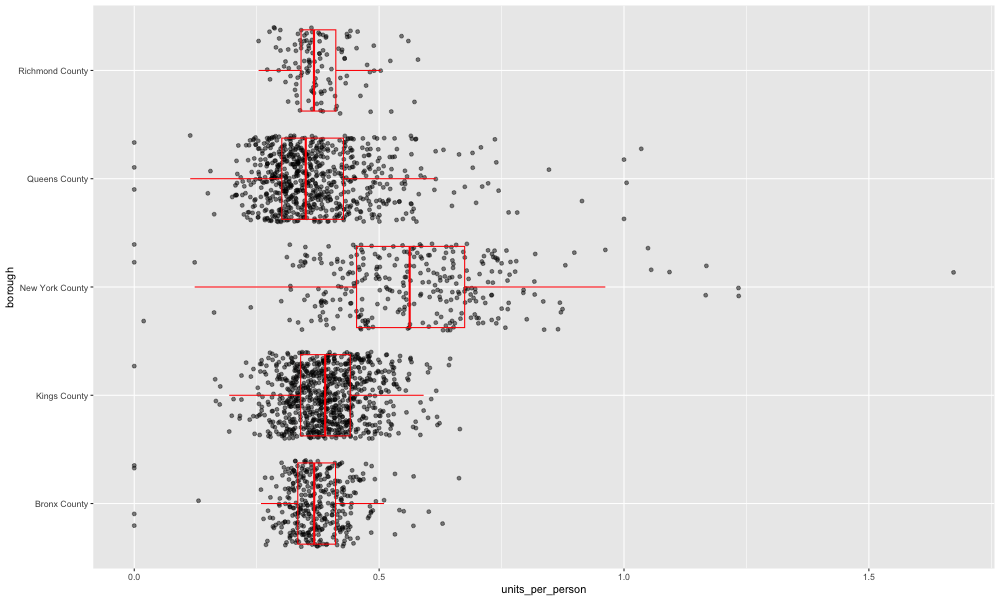

In [55]:
%%R -w 1000 -h 600

ggplot(nyc_census_data) + 
    aes(x=units_per_person, y=borough) +
    geom_jitter(alpha=0.5) + 
    # overlay a box and whisker plot that is transparent with no outliers and is red
    geom_boxplot(fill=NA, outlier.shape=NA, color="red") 

### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

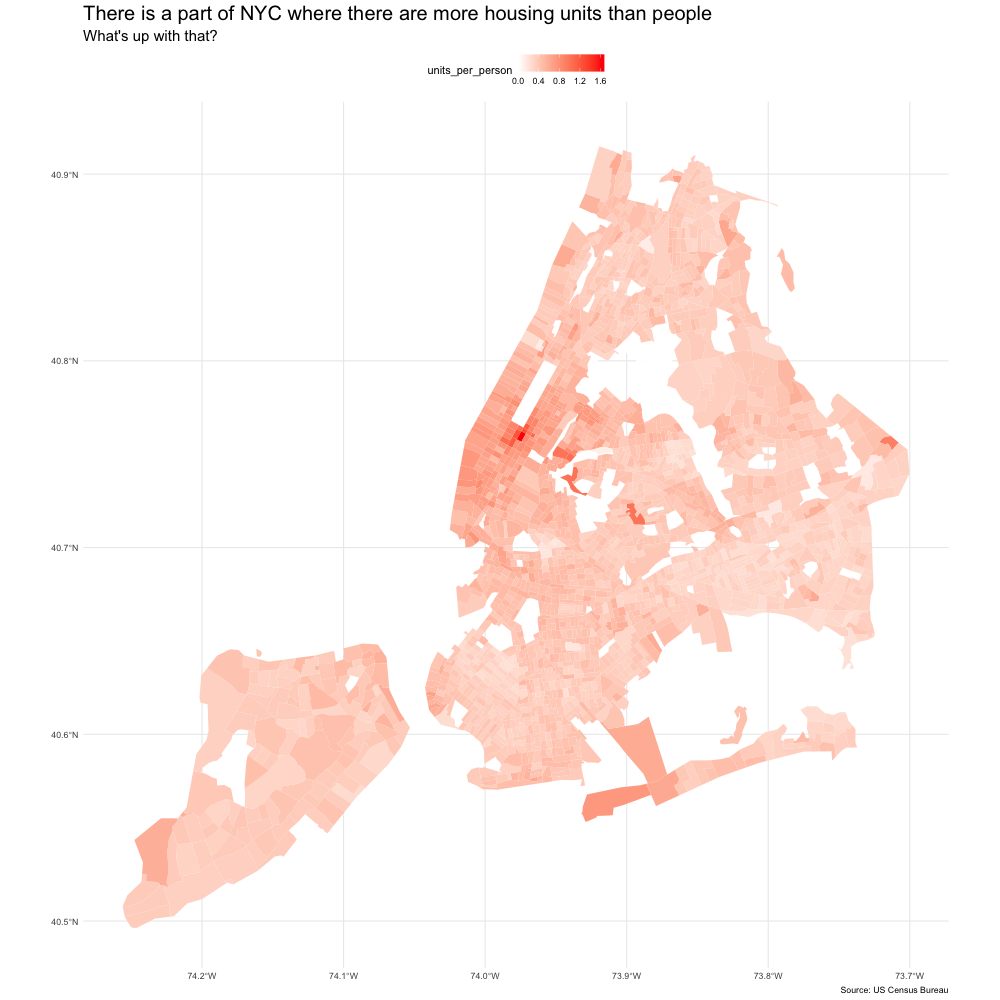

In [56]:
%%R -w 1000 -h 1000

nyc_census_data |>
  ggplot(aes(fill = units_per_person)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  theme_minimal() +
  labs(
    title = "There is a part of NYC where there are more housing units than people",
    subtitle = "What's up with that?",
    caption = "Source: US Census Bureau"
  ) +
  theme(
    #make title and subitle bigger
    plot.title = element_text(size = 20),
    plot.subtitle = element_text(size = 15),
    # move legend to top
    legend.position = "top"
  )


# Step 7 | Hypothesis Test

In this section you will test if the number of units per person is different in census tracts in Manhattan vs Brooklyn.

1. Formulate a null hypothesis (H0) and an alternate hypothesis (Ha)
    - H0: There is no difference in the number of units per person in census tracts in Manhattan vs. Brooklyn
    - Ha: There is a difference in the number of units per person in census tracts in Manhattan vs. Brooklyn
2. Plot the data
3. Apply a t-test
4. Interpret the result 
5. For yourself (using statsy language like "reject the null hypothesis that TKTK" or "fail to reject the null hypothesis that TKTK")
6. For the reader (how would you explain the result to a reader?)




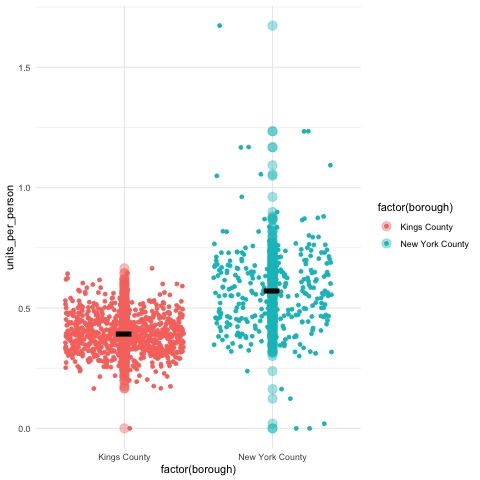

In [57]:
%%R -o mtcars

# R cell

nyc_census_data_bm <- nyc_census_data %>%
    filter(borough == "Kings County" | borough == "New York County")

ggplot(nyc_census_data_bm) +
    aes(x=factor(borough), y=units_per_person, color=factor(borough)) +
    geom_point(size=4, alpha=.4) +
    geom_jitter() +
    stat_summary(fun = "mean", geom = "point", size = 20, shape="-", color="black") +
    theme_minimal()

In [ ]:
%%R

nyc_census_data_bm <- nyc_census_data_bm %>%
    drop_na(units_per_person)

nyc_census_data_b <- nyc_census_data_bm %>%
    filter(borough == "Kings County")
    
nyc_census_data_m <- nyc_census_data_bm %>%
    filter(borough == "New York County")

t.test(nyc_census_data_b$units_per_person, nyc_census_data_m$units_per_person)


	Welch Two Sample t-test

data:  nyc_census_data_b$units_per_person and nyc_census_data_m$units_per_person
t = -16.154, df = 345.91, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:


 -0.2008744 -0.1572694
sample estimates:
mean of x mean of y 
0.3936830 0.5727548 



### With a very low p-value, we reject the null hypothesis that there is no difference in the average units per person in Brooklyn and Manhattan

### Manhattan has, on average, 0.57 units per person, while Brooklyn has 0.4, according to Census data.

👉 Now do the same for census tracts in Bronx vs Queens

1. Formulate a null hypothesis (H0) and an alternate hypothesis (Ha)
    - H0: There is no difference in the number of units per person in census tracts in the Bronx vs. Queens
    - Ha: There is a difference in the number of units per person in census tracts in the Bronx vs. Queens
2. Plot the data
3. Apply a t-test
4. Interpret the result 
5. For yourself (using statsy language like "reject the null hypothesis that TKTK" or "fail to reject the null hypothesis that TKTK")
6. For the reader (how would you explain the result to a reader?)

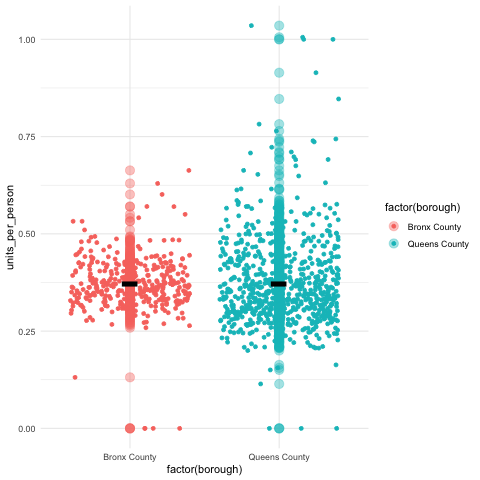

In [61]:
%%R -o mtcars

# R cell

nyc_census_data_xq <- nyc_census_data %>%
    filter(borough == "Bronx County" | borough == "Queens County")

ggplot(nyc_census_data_xq) +
    aes(x=factor(borough), y=units_per_person, color=factor(borough)) +
    geom_point(size=4, alpha=.4) +
    geom_jitter() +
    stat_summary(fun = "mean", geom = "point", size = 20, shape="-", color="black") +
    theme_minimal()

In [63]:
%%R

nyc_census_data_xq <- nyc_census_data_xq %>%
    drop_na(units_per_person)

nyc_census_data_x <- nyc_census_data_xq %>%
    filter(borough == "Bronx County")
    
nyc_census_data_q <- nyc_census_data_xq %>%
    filter(borough == "Queens County")

t.test(nyc_census_data_x$units_per_person, nyc_census_data_q$units_per_person)


	Welch Two Sample t-test

data:  nyc_census_data_x$units_per_person and nyc_census_data_q$units_per_person
t = -0.27603, df = 990.69, p-value = 0.7826
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.013219659  0.009959229
sample estimates:
mean of x mean of y 
0.3717552 0.3733854 



### Based on the p-value 0.783, we fail to reject the null hypothesis.

### There is no statistically significant difference in the number of units per person in the Bronx vs. Queens, based on data from the 2017-2021 American Community Survey.

👉 Now do the same for census tracts in Queens vs Staten Island

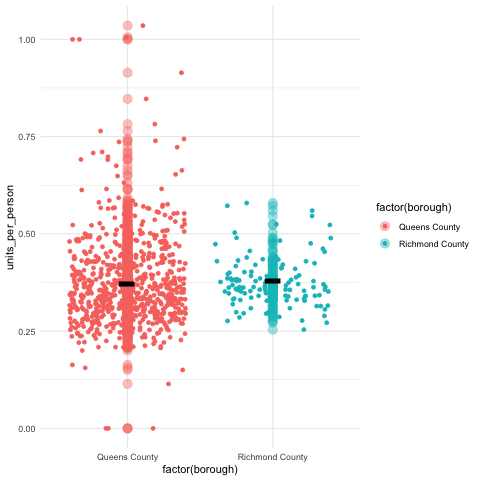

In [65]:
%%R -o mtcars

# R cell

nyc_census_data_rq <- nyc_census_data %>%
    filter(borough == "Richmond County" | borough == "Queens County")

ggplot(nyc_census_data_rq) +
    aes(x=factor(borough), y=units_per_person, color=factor(borough)) +
    geom_point(size=4, alpha=.4) +
    geom_jitter() +
    stat_summary(fun = "mean", geom = "point", size = 20, shape="-", color="black") +
    theme_minimal()

In [66]:
%%R

nyc_census_data_rq <- nyc_census_data_rq %>%
    drop_na(units_per_person)

nyc_census_data_r <- nyc_census_data_rq %>%
    filter(borough == "Richmond County")
    
nyc_census_data_q <- nyc_census_data_rq %>%
    filter(borough == "Queens County")

t.test(nyc_census_data_r$units_per_person, nyc_census_data_q$units_per_person)


	Welch Two Sample t-test

data:  nyc_census_data_r$units_per_person and nyc_census_data_q$units_per_person
t = 0.82991, df = 282.66, p-value = 0.4073
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.008353291  0.020531875
sample estimates:
mean of x mean of y 
0.3794747 0.3733854 



### Based on the p-value 0.407, we fail to reject the null hypothesis.

### There is no statistically significant difference in the number of units per person in the Staten Island vs. Queens, based on data from the 2017-2021 American Community Survey.

👉 make a copy of this notebook (or revisit your ggplot-census notebook), modify the census variable and run it again for something other than housing "units per person"